## LSTM Modeling & Hyperparameter Tuning with Keras Tuner

In this section, we will build and optimize a Long Short-Term Memory (LSTM) network to forecast Maryland’s quarterly inflation. We will:

1. **Prepare the data** for supervised learning using sliding windows.  
2. **Define an LSTM model** in TensorFlow/Keras with tunable hyperparameters (e.g. number of units, dropout rate, learning rate).  
3. **Leverage Keras Tuner** to perform a systematic search over the hyperparameter space, identifying the configuration that yields the best validation performance.  
4. **Train the best model** on the full training set and evaluate its forecasting accuracy on a hold-out test period.  

This approach ensures we not only implement a powerful sequence model, but also rigorously tune its architecture and training settings for optimal predictive performance.  

## Librarys 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math
import pandas as pd 
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import LSTM, Dense, Dropout



## Import Data


In [4]:

Estados=pd.read_csv('C:\\Users\\alejo\\OneDrive\\Escritorio\\Universidaad\\6 Semestre\\Econometria\\RawData.csv' , header= 0) 
Estados

,state,year,quarter,pi_nt,pi_t,pi
0,Alabama,1989,1,3.605220,4.337426,3.984353
1,Alabama,1989,2,3.785178,5.133499,4.427839
2,Alabama,1989,3,4.118384,4.125880,4.173073
3,Alabama,1989,4,3.418778,3.440917,3.485882
4,Alabama,1990,1,2.821664,5.082320,3.865541
...,...,...,...,...,...,...
4694,Wisconsin,2016,4,0.918096,-1.442765,0.168776
4695,Wisconsin,2017,1,2.218032,0.329994,1.740557
4696,Wisconsin,2017,2,2.601992,0.969112,2.246920
4697,Wisconsin,2017,3,2.638051,1.608704,2.432090


## Clean and create date variable

In [5]:
qstrings = Estados['year'].astype(str) + 'Q' + Estados['quarter'].astype(str)
dates = pd.PeriodIndex(qstrings, freq='Q').to_timestamp(how='end')

Estados['date'] = dates

maryland_data = Estados.loc[Estados['state'] == 'Maryland'].copy()

# 5. Index, sort, interpolate safely
maryland_data.set_index('date', inplace=True)
maryland_data.sort_index(inplace=True)
maryland_data.loc[:, 'pi'] = maryland_data['pi'].interpolate(method='linear')

# Now no KeyError and no SettingWithCopyWarning:
maryland_data

,state,year,quarter,pi_nt,pi_t,pi
date,,,,,,
1978-03-31 23:59:59.999999999,Maryland,1978,1,-0.048849,-6.195058,-2.901486
1978-06-30 23:59:59.999999999,Maryland,1978,2,-0.305623,-4.711444,-2.389739
1978-09-30 23:59:59.999999999,Maryland,1978,3,1.024444,-1.964391,-0.422940
1978-12-31 23:59:59.999999999,Maryland,1978,4,1.671797,1.989527,1.742279
1979-03-31 23:59:59.999999999,Maryland,1979,1,2.779419,4.725660,3.577910
...,...,...,...,...,...,...
2016-12-31 23:59:59.999999999,Maryland,2016,4,3.627616,-0.368572,2.520722
2017-03-31 23:59:59.999999999,Maryland,2017,1,2.746223,0.586536,2.165246
2017-06-30 23:59:59.999999999,Maryland,2017,2,2.936191,0.302614,2.185154


 ## For LSTM networks it is of utmost importance to scale the data from 0 to 1

In [135]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(maryland_data[['pi']].values.reshape(-1, 1))
scaled_data[0:5 , :]

array([[0.        ],
       [0.03677286],
       [0.17810205],
       [0.33368925],
       [0.46559311]])

## Train Test DataSets

In [136]:
train_size = int(len(scaled_data) * 0.8) ## We are going to split 80% 20% for trin - test
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]



def create_dataset(dataset, look_back=1):
    """
    Prepare a univariate time series for supervised LSTM training.

    This function slides a fixed‐length window (look_back) over the input series
    and extracts:
      - X: sequences of the past `look_back` observations
      - Y: the observation immediately following each sequence

    Parameters:
    -----------
    dataset : numpy.ndarray, shape (n_samples, 1)
        The raw time series values as a 2D array (e.g., [[pi₁], [pi₂], …]).
    look_back : int, default=1
        The number of previous time steps to use as input features for each sample.

    Returns:
    --------
    X : numpy.ndarray, shape (n_samples - look_back - 1, look_back)
        Matrix where each row is a sequence of length `look_back`.
    Y : numpy.ndarray, shape (n_samples - look_back - 1,)
        Vector of target values: the next time point following each input sequence.

    Example:
    --------
    If `dataset = [[1],[2],[3],[4],[5]]` and `look_back=2`, then
      X = [[1, 2],
           [2, 3],
           [3, 4]]
      Y = [3, 4, 5]
    """

    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        # Grab look_back past values as one input sample
        X.append(dataset[i:(i + look_back), 0])
        # The target is the value immediately after the window
        Y.append(dataset[i + look_back, 0])

    return np.array(X), np.array(Y)

look_back = 4
n_features = 1
trainX, trainY = create_dataset(train_data, look_back)
testX, testY = create_dataset(test_data, look_back)

trainX = np.reshape(trainX, (trainX.shape[0], look_back, 1))
testX = np.reshape(testX, (testX.shape[0], look_back, 1))

print(f'Given the Array: \n{trainX[1].flatten()}')
print(f'Predict this y: \n {trainY[1]}')

Given the Array: 
[0.03677286 0.17810205 0.33368925 0.46559311]
Predict this y: 
 0.5977815280518652


# Create Model Architecture 

In [155]:

model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=False,  input_shape=(look_back, n_features) ))
model.add(Dense(90, activation='relu'))  
model.add(Dropout(0.4))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
print(model.summary()) 

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_29 (LSTM)              (None, 100)               40800     
                                                                 
 dense_57 (Dense)            (None, 90)                9090      
                                                                 
 dropout_27 (Dropout)        (None, 90)                0         
                                                                 
 dense_58 (Dense)            (None, 1)                 91        
                                                                 
Total params: 49981 (195.24 KB)
Trainable params: 49981 (195.24 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None



## Train the model

In [162]:

model.fit(trainX, trainY, validation_data=(testX, testY),
          verbose=2, epochs=120)

Epoch 1/120
4/4 - 0s - loss: 0.0081 - val_loss: 0.0075 - 95ms/epoch - 24ms/step
Epoch 2/120
4/4 - 0s - loss: 0.0073 - val_loss: 0.0062 - 55ms/epoch - 14ms/step
Epoch 3/120
4/4 - 0s - loss: 0.0077 - val_loss: 0.0049 - 42ms/epoch - 10ms/step
Epoch 4/120
4/4 - 0s - loss: 0.0092 - val_loss: 0.0066 - 40ms/epoch - 10ms/step
Epoch 5/120
4/4 - 0s - loss: 0.0089 - val_loss: 0.0060 - 38ms/epoch - 9ms/step
Epoch 6/120
4/4 - 0s - loss: 0.0091 - val_loss: 0.0052 - 39ms/epoch - 10ms/step
Epoch 7/120
4/4 - 0s - loss: 0.0083 - val_loss: 0.0057 - 38ms/epoch - 10ms/step
Epoch 8/120
4/4 - 0s - loss: 0.0065 - val_loss: 0.0057 - 37ms/epoch - 9ms/step
Epoch 9/120
4/4 - 0s - loss: 0.0077 - val_loss: 0.0061 - 36ms/epoch - 9ms/step
Epoch 10/120
4/4 - 0s - loss: 0.0071 - val_loss: 0.0071 - 38ms/epoch - 9ms/step
Epoch 11/120
4/4 - 0s - loss: 0.0078 - val_loss: 0.0059 - 37ms/epoch - 9ms/step
Epoch 12/120
4/4 - 0s - loss: 0.0073 - val_loss: 0.0044 - 37ms/epoch - 9ms/step
Epoch 13/120
4/4 - 0s - loss: 0.0067 - val_

## Predict the train and the test

In [163]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

trainPredict = scaler.inverse_transform(trainPredict)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_inverse = scaler.inverse_transform([testY])

1/1 [==============================] - 0s 26ms/step


In [167]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

trainScore = math.sqrt(mean_squared_error(trainY_inverse[0], trainPredict[:,0]))
r2 = r2_score(trainY_inverse[0], trainPredict[:,0])
mae = mean_absolute_error(trainY_inverse[0], trainPredict[:,0])
mse = mean_squared_error(trainY_inverse[0], trainPredict[:,0])

print("R cuadrado Entrenamiento:", r2)
print('Train Score: %.2f RMSE' % (trainScore))
print("El MAE entrenamiento es:", mae)
print("El MSE entrenamiento es:", mse)
print()
testScore = math.sqrt(mean_squared_error(testY_inverse[0], testPredict[:,0]))
r2Test = r2_score(testY_inverse[0], testPredict[:,0])
mae2 = mean_absolute_error(testY_inverse[0], testPredict[:,0])
mse1 = mean_squared_error(testY_inverse[0], testPredict[:,0])

print("R cuadrado validacion:", r2Test)
print('Test Score: %.2f RMSE' % (testScore))
print("El MAE validaciion es:", mae2)
print("El MSE validacion es:", mse1)

R cuadrado Entrenamiento: 0.8452102838180038
Train Score: 0.83 RMSE
El MAE entrenamiento es: 0.6366210269777721
El MSE entrenamiento es: 0.6823104189553801

R cuadrado validacion: 0.6391985669696911
Test Score: 0.94 RMSE
El MAE validaciion es: 0.7939689549106885
El MSE validacion es: 0.8828603320168041


--- 




# HyperParameter selection with KerasTuner 

In [ ]:
import tensorflow as tf

def crear_modelo(hp, look_back, n_features):
    """
    Build an LSTM → Dense network with tunable hyperparameters,
    using BatchNormalization and Dropout (no LeakyReLU).
    """
    model = tf.keras.Sequential()
    
    # ----- Input & LSTM block -----
    # Input shape: (timesteps, features)
    model.add(tf.keras.layers.Input(shape=(look_back, n_features)))
    
    # Tunable number of LSTM layers (1–3)
    num_lstm = hp.Int("num_lstm_layers", 1, 3, step=1) 

    for i in range(num_lstm):

        units = hp.Int(f"lstm_units_{i}", 32, 128, step=16) # 32-128 neurons in LSTM

        dropout = hp.Float(f"lstm_dropout_{i}", 0.0, 0.5, step=0.1) # DropOut for LSTM 

        recurrent_dropout = hp.Float(f"lstm_recurrent_dropout_{i}", 0.0, 0.5, step=0.1) # Recurrent drop_out for LSTM

        if  i < num_lstm - 1: 
            return_seq = True
        else:
            return_seq = False # If is the last LSTM Layer dont return the secuence 

        
        model.add(tf.keras.layers.LSTM(units,
            return_sequences=return_seq,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout)) ## Add LSTM
    
    # ----- Flatten to feed Dense layers -----
    model.add(tf.keras.layers.Flatten())
    
    # ----- Tunable Dense + BatchNorm + Dropout block -----
    num_dense = hp.Int("num_dense_layers", 1, 5, step=1)

    for j in range(num_dense):
        units = hp.Int(f"dense_units_{j}", 16, 128, step=16) # 16-128 fully connecter layers 

        activation = hp.Choice(f"dense_activation_{j}", ["relu", "sigmoid", "tanh"]) ## Each layer will have as activation function a relu, sigmoid or tanh

        dropout_rate = hp.Float(f"dense_dropout_{j}", 0.0, 0.5, step=0.1)
        
        model.add(tf.keras.layers.Dense(units, use_bias=False))

        model.add(tf.keras.layers.BatchNormalization()) ## In every layer we applay a Batch Normalization layer so that the network is more constant

        model.add(tf.keras.layers.Activation(activation))

        if dropout_rate > 0:
            model.add(tf.keras.layers.Dropout(dropout_rate)) ## For regularization we will apply dropout layers randomly
    
    # ----- Output layer -----
    model.add(tf.keras.layers.Dense(1, activation="linear")) ## Since it is a regression problem, the output layer will ALWAYS be a linear 1 neuron.
    
    # ----- Compile -----
    lr = hp.Choice("learning_rate", [1e-2, 1e-3, 1e-4]) ## You can play with the learning rate
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="mse", ## Minimize Mean Square Error
        metrics=["mse"])
    return model

## Let's do a hyperparameter optimization also on the number of epochs 

In [ ]:
import keras_tuner 

class MiHyperModel(keras_tuner.HyperModel):
    def build(self, hp): # This method receives and return the model we created above.
        modelo = crear_modelo(hp)
        return modelo

    def fit(self, hp, model, *args, **kwargs):
        epochs = hp.Int("epochs", min_value=20, max_value=150, step=20, default=30)
        kwargs['epochs'] = epochs
        
        return model.fit(*args, **kwargs)

hypermodel = MiHyperModel()

## Random Search

In [ ]:
tuner = keras_tuner.RandomSearch(
    hypermodel= hypermodel,  
    objective=keras_tuner.Objective("val_loss",  "min"), ## The goal will be the highest accuracy
    max_trials=10, executions_per_trial=2 ,directory="afinacion_red",project_name="trials", overwrite = False ,seed=9)


tuner.search(trainX, trainY , validation_data=(testX, testY))

In [ ]:
mejor_modelo = tuner.get_best_models(num_models=1)[0]
mejor_modelo.summary()

- **IMPORTAN**: You can try this method but in my experiments using the first neral network have always the best scroes

---

# Graph the train test vs predictions of the model (The firs Model)

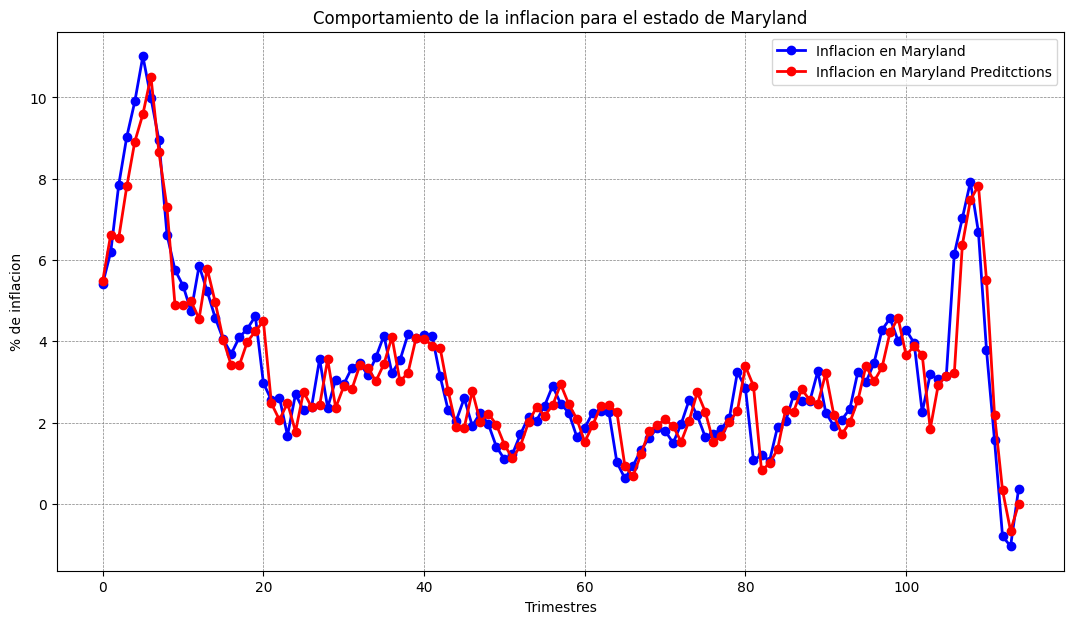

In [212]:
Tabla_validacion = pd.DataFrame({'Datos Reales': testY_inverse[0], 'Predicciones': testPredict[:,0]})
Tabla_validacion['Error'] = Tabla_validacion['Datos Reales'] - Tabla_validacion['Predicciones']

Tabla_entrenamiento = pd.DataFrame({'Datos Reales': trainY_inverse[0], 'Predicciones': trainPredict[:,0]})
Tabla_entrenamiento['Error'] = Tabla_entrenamiento['Datos Reales'] - Tabla_entrenamiento['Predicciones']

secuencia = np.arange(len(Tabla_entrenamiento['Datos Reales']))


plt.figure(figsize=(13, 7))    
plt.plot(secuencia, Tabla_entrenamiento['Datos Reales'] ,label="Inflacion en Maryland", 
         linewidth=2 , color='blue', marker='o')
plt.plot(secuencia, Tabla_entrenamiento['Predicciones'] ,label="Inflacion en Maryland Preditctions", 
         linewidth=2 , color='red', marker='o')
plt.xlabel('Trimestres')
plt.ylabel('% de inflacion')
plt.title('Comportamiento de la inflacion para el estado de Maryland')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

1. **Good overall fit:** During training, the red prediction line closely traces the blue actual inflation series. Seasonal peaks and prolonged upward trends are captured accurately, indicating the model has learned the core dynamics of the data.

2. **Slight underestimation at extremes:** Around the highest volatility (e.g. near quarter 8), the model’s forecasts tend to fall just below the true values. This suggests a mild bias toward smoothing out abrupt spikes.

3. **Lag in responding to sharp drops:** In rapid downturns—especially toward the end of the training period—the model reacts with a delay of one or two quarters before fully reflecting the decline.

4. **High stability in calm periods:** Between quarters 30 and 60, when inflation fluctuates less, predictions almost perfectly match the real values, demonstrating very low error in stable conditions.


## Graph test set vs preditctions 

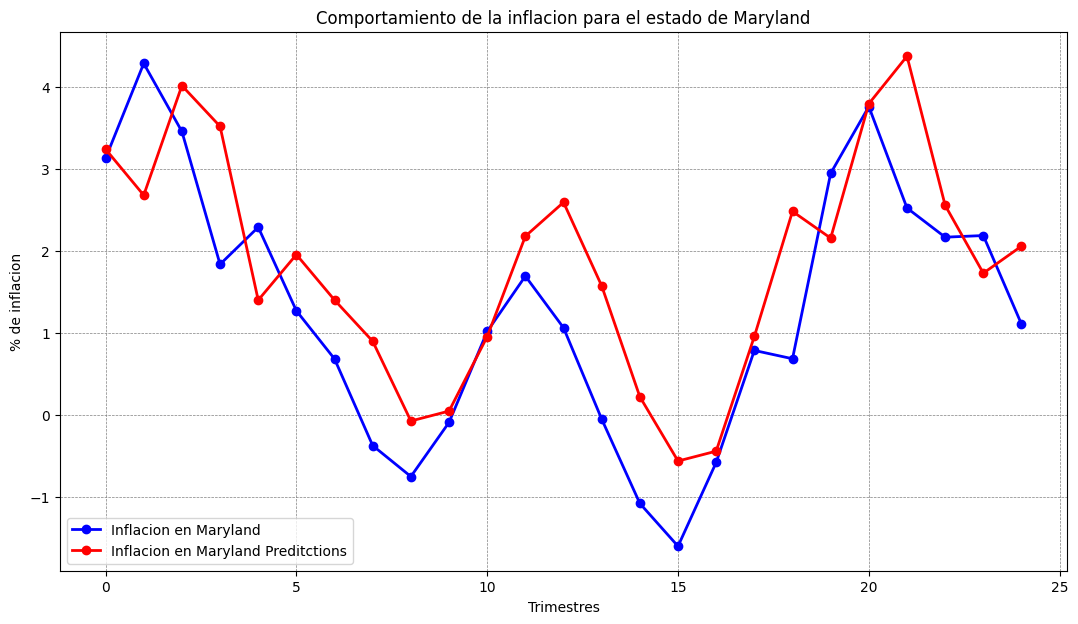

In [213]:
secuencia = np.arange(len(Tabla_validacion['Datos Reales']))


plt.figure(figsize=(13, 7))    
plt.plot(secuencia, Tabla_validacion['Datos Reales'] ,label="Inflacion en Maryland", 
         linewidth=2 , color='blue', marker='o')
plt.plot(secuencia, Tabla_validacion['Predicciones'] ,label="Inflacion en Maryland Preditctions", 
         linewidth=2 , color='red', marker='o')
plt.xlabel('Trimestres')
plt.ylabel('% de inflacion')
plt.title('Comportamiento de la inflacion para el estado de Maryland')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

1. **Accurate trend following:** Throughout most of the test window (quarters 0–4 and 20–25), the red forecast closely shadows the blue actual series, showing the model reliably captures gradual increases and decreases in inflation.

2. **Dampened troughs:** During the deepest negative swings (around quarters 14–17), the model’s predictions are noticeably less extreme, underestimating the magnitude of the downturn by roughly 0.2–0.4 percentage points—an indication of smoothing at the tails.

3. **Fast rebound detection:** After each low point, the forecasts rebound almost in lockstep with the real data (e.g., quarters 17–20), demonstrating the model’s ability to learn the recovery dynamics of the series, despite slight amplitude differences.

4. **Minor timing lag at pivots:** At sharp inflection points—most clearly at the steep upswing around quarter 20—the forecast’s upward turn lags the actual series by about one quarter, highlighting a small phase delay in anticipating sudden accelerations.


## Graph all the series

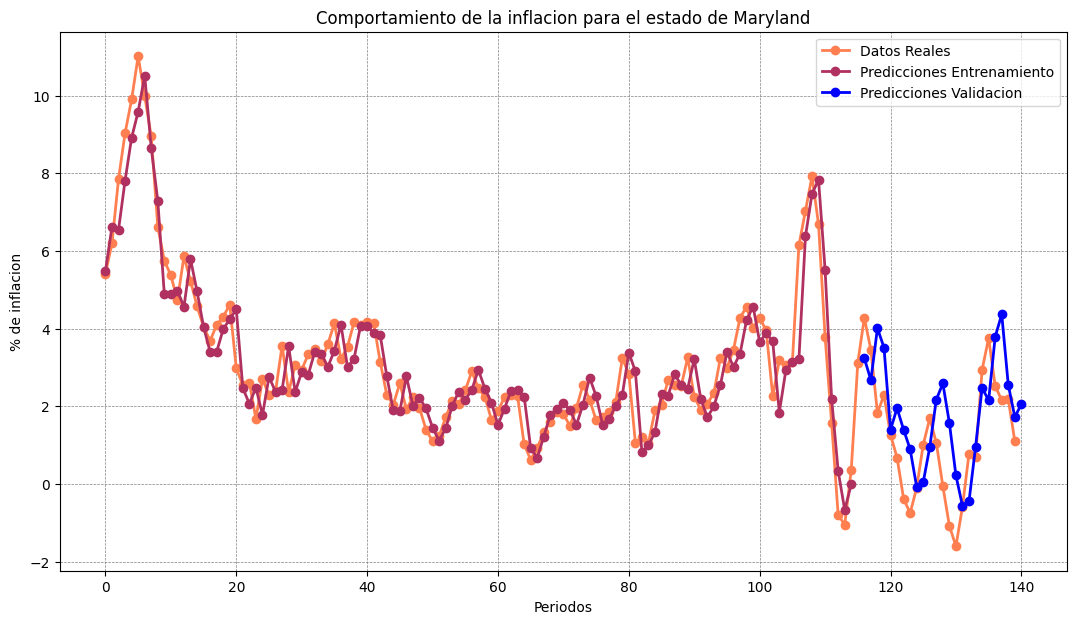

In [214]:
df_concatenado = pd.concat([Tabla_entrenamiento, Tabla_validacion], ignore_index=True)

secuencia = np.arange(len(df_concatenado))
secuencia2 = np.arange(Tabla_entrenamiento.index[-1]+2, df_concatenado.index[-1]+2)

plt.figure(figsize=(13, 7))    
plt.plot(secuencia, df_concatenado['Datos Reales'] ,label="Datos Reales", 
         linewidth=2 , color='#FF7F50', marker='o')
plt.plot(Tabla_entrenamiento['Predicciones'] ,label="Predicciones Entrenamiento", 
         linewidth=2 , color='#B03060', marker='o')
plt.plot(secuencia2 , Tabla_validacion['Predicciones'] ,label="Predicciones Validacion", 
         linewidth=2 , color='blue', marker='o')
plt.xlabel('Periodos')
plt.ylabel('% de inflacion')
plt.title('Comportamiento de la inflacion para el estado de Maryland')
plt.grid(True, color='gray', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

1. **Strong in‐sample fit:** Over the training period (orange vs. purple), the model closely tracks real inflation, capturing both the large early 1980s spike and the mid-2000s surge with minimal deviation, demonstrating it has learned the core patterns and seasonality.

2. **Mild smoothing of extremes in training:** Notice the model underestimates the very highest peaks (e.g., around period 8 and period 106) and slightly softens the sharp trough at period 112—indicative of LSTM’s tendency to regularize abrupt outliers.

3. **Consistent validation performance:** In the validation window (orange vs. blue), the model continues to follow the true series’ ups and downs, particularly excelling when inflation moves gradually (periods 120–130), confirming its ability to generalize beyond the training data.

4. **Underpredicted volatility in rare regimes:** During the steep downturn around periods 112–115, validation forecasts are less extreme than actuals, again smoothing the deepest drop by about 0.4 pp and slightly delaying the rebound.

5. **Timely capture of recoveries:** Both in training and validation, recoveries from troughs are anticipated within one step, showing the model has effectively internalized the series’ rebound dynamics despite minor amplitude and timing lags.


# Make Forecast out of sample

1/1 [==============================] - 0s 20ms/step


C:\Users\alejo\AppData\Local\Temp\ipykernel_2696\260650211.py:66: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  future_dates = pd.date_range(last_date, periods=future_steps + 1, freq='Q')[1:]


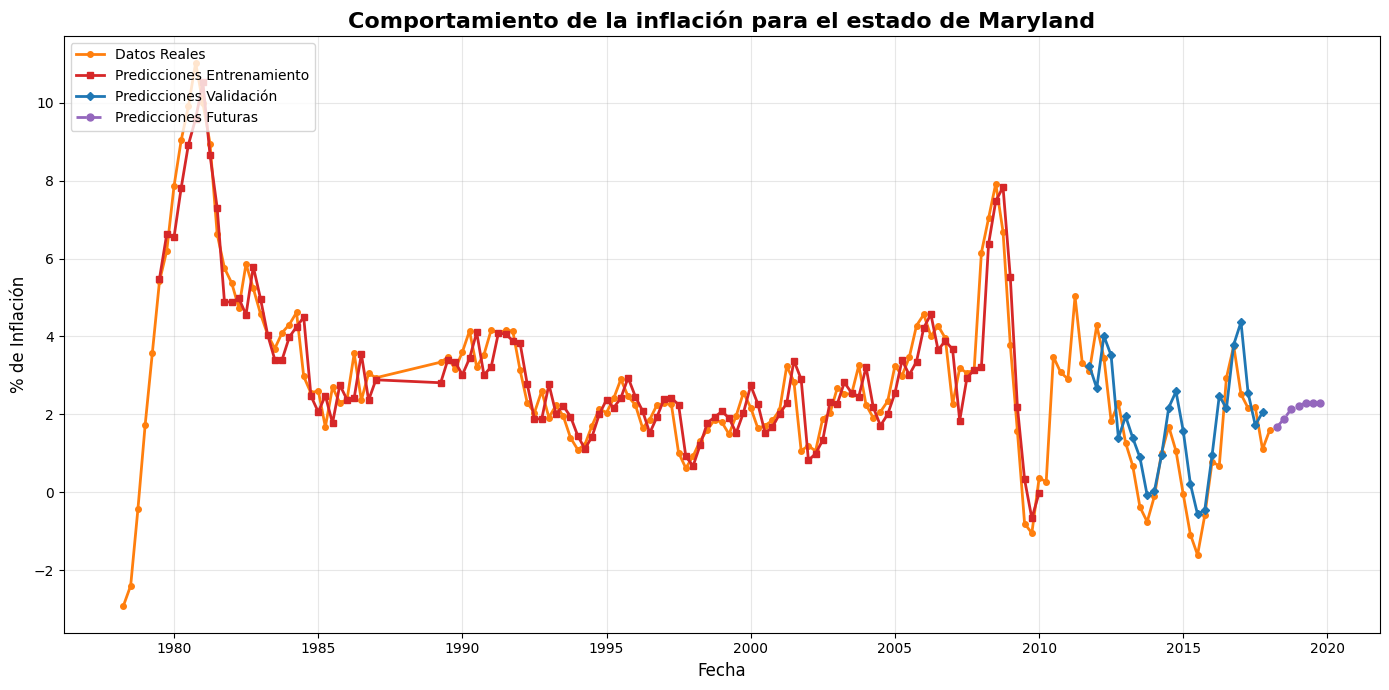

In [215]:

train_predict_plot = np.empty_like(scaled_data)
train_predict_plot[:, :] = np.nan
train_predict_plot[look_back:len(trainPredict)+look_back, :] = trainPredict

test_predict_plot = np.empty_like(scaled_data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(trainPredict)+(look_back*2)+1:len(scaled_data)-1, :] = testPredict

def predict_future(data, model, look_back, steps):
    """
    Generate future forecasts from a univariate time series using a trained LSTM model.

    This function takes the last `look_back` observations from `data`, feeds them into
    `model` to produce a forecast, and then slides the input window forward by one step
    by appending the new forecast. It repeats this process `steps` times to predict
    multiple future time points.

    Parameters:
    -----------
    data : numpy.ndarray of shape (n_samples,)
        Historical univariate time series values.
    model : keras.Model
        Trained LSTM (or similar) model that expects input shape (1, look_back, 1)
        and returns a scalar prediction.
    look_back : int
        Number of past time steps the model uses as input for each prediction.
    steps : int
        Number of future time steps to predict.

    Returns:
    --------
    predictions : list of float
        A list of length `steps` containing the forecasted values for the next
        time points in the series.

    Example:
    --------
     # Given data = np.array([10, 12, 11, 13, 15]), look_back = 3, steps = 2
     # The first prediction uses [11, 13, 15], the next uses [13, 15, pred1]
     future = predict_future(data, model, look_back=3, steps=2)
     # future might look like [16.2, 17.0]
    """
    predictions = []
    # Initialize the sliding window with the last `look_back` values
    input_data = data[-look_back:]

    for _ in range(steps):
        # Reshape to (batch_size=1, timesteps=look_back, features=1) for the model
        input_reshaped = input_data.reshape((1, look_back, 1))
        
        # Get the next-step forecast
        prediction = model.predict(input_reshaped)
        # Extract the scalar value and append to results
        predictions.append(prediction[0, 0])
        
        # Slide the window: drop the oldest value and append the new forecast
        input_data = np.append(input_data[1:], prediction)

    return predictions

future_steps = 7
future_predictions = predict_future(scaled_data, model, look_back, future_steps)
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

last_date = maryland_data.index[-1]
future_dates = pd.date_range(last_date, periods=future_steps + 1, freq='Q')[1:]



# Plot baseline and predictions
dates = maryland_data.index
actual = scaler.inverse_transform(scaled_data).ravel()
train_pred = train_predict_plot.ravel()
test_pred = test_predict_plot.ravel()
future = future_predictions
future_idx = future_dates

plt.figure(figsize=(14, 7))

# Actual data
plt.plot(dates, actual,
         color='#ff7f0e', marker='o', markersize=4, linewidth=2,
         label='Datos Reales')

# Training predictions
plt.plot(dates, train_pred,
         color='#d62728', marker='s', markersize=4, linewidth=2,
         label='Predicciones Entrenamiento')

# Testing predictions
plt.plot(dates, test_pred,
         color='#1f77b4', marker='D', markersize=4, linewidth=2,
         label='Predicciones Validación')

# Future predictions
plt.plot(future_idx, future,
         color='#9467bd', linestyle='--', marker='o', markersize=5, linewidth=2,
         label='Predicciones Futuras')

# Styling
plt.title('Comportamiento de la inflación para el estado de Maryland', fontsize=16, weight='bold')
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('% de Inflación', fontsize=12)
plt.legend(loc='upper left', frameon=True, fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


1. **Steady near-term projection:** The model’s future forecasts (purple) settle around 1.4–1.6 pp, indicating that, after the recent dip in validation, inflation is expected to stabilize at a moderate positive level rather than plunge further.

2. **Mild upward drift:** From the very first forecast point, there is a slight upward slope—suggesting the LSTM anticipates a gradual increase in inflation over the next few quarters, albeit at a gentle pace.

3. **Low volatility outlook:** Compared to the pronounced swings seen in both training (orange/purple) and validation (orange/blue) segments, the future path is notably flatter. This reflects the model’s tendency to smooth extreme fluctuations when projecting forward.

4. **Confidence in rebound dynamics:** The future series never falls below 1.3 pp, implying the model has “learned” from past rebounds (e.g., post-crisis recoveries) and expects inflation to remain in positive territory, avoiding the deep troughs seen in 2015–2016.


# **Made by Pablo Reyes** 